# Gibbs sampling for linear regression in Python

In [20]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "out",
                 "ytick.direction": "out"})
    rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False
}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize


# Bayesian linear regression

Here we are interested in Gibbs sampling for normal linear regression with one independent variable. We assume we have paired data  \\( (y_i, x_i) , i = 1, \ldots, N \\). We wish to find the posterior distributions of the coefficients \\(\beta_0\\) (the intercept), \\(\beta_1\\) (the gradient) and of the precision $\tau$ which is the reciprocal of the variance. The model can be written as 

$$ y_i \sim \mathcal{N}(\beta_0 + \beta_1 x_i, 1 / \tau) $$

or equivalently

$$ y_i = \beta_0 + \beta_1 x_i + \epsilon, \; \; \epsilon \sim \mathcal{N}(0, 1 / \tau) $$

The likelihood for this model may be written as

$$ L(y_1, \ldots, y_N, x_1, \ldots, x_N | \beta_0, \beta_1, \tau) = \prod_{i = 1}^N \mathcal{N}(\beta_0 + \beta_1 x_i, 1 / \tau) $$

We also wish to place [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) on \\(\beta_0\\), \\(\beta_1\\) and \\(\tau\\) for reasons that will become apparent later. For these we choose

$$ \beta_0 \sim \mathcal{N}(\mu_0, 1 / \tau_0) $$

$$ \beta_1 \sim \mathcal{N}(\mu, 1 / \tau_1) $$

$$ \tau \sim \text{Gamma}(\alpha, \beta) $$

# Gibbs sampling

[Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) works as follows: suppose we have two parameters \\(\theta_1\\) and \\(\theta_2\\) and some data \\(x\\). Our goal is to find the posterior distribution of \\(p(\theta_1, \theta_2 \| x)\\). To do this in a Gibbs sampling regime we need to work out the conditional distributions \\(p(\theta_1 \| \theta_2, x)\\) and \\(p(\theta_2 \| \theta_1, x)\\) (which is typically the hard part). The Gibbs updates are then

1. Pick some initial \\(\theta_2^{(i)}\\).
2. Sample \\( \theta_1^{(i+1)} \sim p(\theta_1 \| \theta_2^{(i)}, x) \\)
3. Sample \\( \theta_2^{(i+1)} \sim p(\theta_2 \| \theta_1^{(i+1)}, x) \\)

Then increment \\(i\\) and repeat \\(K\\) times to draw \\(K\\) samples. This is equivalent to sampling new values for a given variable *while holding all others constant*. The key thing to remember in Gibbs sampling is to always use the most recent parameter values for all samples (e.g. sample \\(\theta_2^{(i+1)} \sim p(\theta_2 \| \theta_1^{(i+1)}, x)\\) and not \\(\theta_2^{(i+1)} \sim p(\theta_2 \| \theta_1^{(i)}, x)\\) provided \\(\theta_1^{(i+1)}\\) has already been sampled).

The massive advantage of Gibbs sampling over other MCMC methods (namely Metropolis-Hastings) is that no tuning parameters are required! The downside is the need of a fair bit of maths to derive the updates, which even then aren't always guaranteed to exist.

## Deriving a Gibbs sampler

The general approach to deriving an update for a variable is 

1. Write down the posterior conditional density in log-form
2. Throw away all terms that don't depend on the current sampling variable
3. Pretend this is the density for your variable of interest and all other variables are fixed. What distribution does the log-density remind you of?
4. That's your conditional sampling density!

We go through this for our three variables step by step below.

### Updates for \\(\beta_0\\)

We're interested in finding

$$ p(\beta_0 | \beta_1, \tau, y, x) \propto p(y, x | \beta_0, \beta_1, \tau) p(\beta_0) $$


Note that \\(p(y, x \| \beta_0, \beta_1, \tau)\\) is just the likelihood from above and \\(p(\beta_0)\\) is simply \\(\mathcal{N}(\mu_0, 1 / \tau_0)\\). 

If a variable \\(x\\) follows a normal distribution with mean \\(\mu\\) and precision \\(\tau\\) then the log-dependence on \\(x\\) is \\(-\frac{\tau}{2}(x - \mu)^2 \propto -\frac{\tau}{2} x^2 + \tau \mu x\\). So if we can force the log-posterior conditional density into a quadratic form then the coefficient of \\(x^2\\) (where \\(x\\) is the variable of interest) will be \\(\tau \mu\\) and the coefficient of \\(x^2\\) will be \\(-\frac{\tau}{2}\\). 

Hence the log-dependence on \\(\beta_0\\) is

$$ -\frac{\tau_0}{2}(\beta_0 - \mu_0)^2 - \frac{\tau}{2} \sum_{i=1}^N (y_i - \beta_0 - \beta_1 x_i)^2 $$

Although it's perhaps not obvious, this expression is quadratic in \\(\beta_0\\), meaning the conditional sampling density for \\(\beta_0\\) will also be normal. A bit of algebra (dropping all terms that don't involve \\(\beta_0\\) takes us to

$$ -\frac{\tau_0}{2} \beta_0^2 +\tau_0 \mu_0 \beta_0 -\frac{\tau}{2} N \beta_0^2 
+ \tau \sum_i (y_i - \beta_1 x_i) \beta_0$$

In other words the coefficient of \\(\beta_0\\) is \\(\tau_0 \mu_0 + \tau \sum_i (y_i - \beta_1 x_i) \\) while the coefficient of \\(\beta_0^2\\) is \\(-\frac{\tau_0}{2} -\frac{\tau}{2} N\\). This implies the conditional sampling distribution of \\(\beta_0\\) is

$$ \beta_0 | \beta_1, \tau, \tau_0, \mu_0, x, y \sim \mathcal{N}\left( \frac{\tau_0 \mu_0 + \tau \sum_i (y_i - \beta_1 x_i)}{\tau_0 + \tau N}, 1 / (\tau_0 + \tau N) \right) $$

Let's turn that into a python function:

In [68]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

Sweet! Now back to the maths.

### Update for \\(\beta_1\\)

Similarly to \\(\beta_0\\), the dependence of the conditional log-posterior is given by

$$ -\frac{\tau_1}{2}(\beta_1 - \mu_1)^2 - \frac{\tau}{2} \sum_{i=1}^N (y_i - \beta_0 - \beta_1 x_i)^2 $$

which if we expand out and drop all terms that don't include \\(\beta_1\\) we get

$$ -\frac{\tau_1}{2} \beta_1^2 +\tau_1 \mu_1 \beta_1 -\frac{\tau}{2} \sum_i x_i^2 \beta_1^2 
+ \tau \sum_i (y_i - \beta_0) x_i \beta_1$$

so the coefficient of \\(\beta_1\\) is \\(\tau_1 \mu_1 + \tau  \sum_i (y_i - \beta_0) x_i\\) while the coefficient of \\(\beta_1^2\\) is  \\(-\frac{\tau_1}{2} -\frac{\tau}{2} \sum_i x_i^2\\). Therefore the conditional sampling density of \\(\beta_1\\) is 

$$ \beta_1 | \beta_0, \tau, \mu_1, \tau_1, x, y \sim \mathcal{N}\left( \frac{\tau_1 \mu_1 + \tau  \sum_i (y_i - \beta_0) x_i}{\tau_1 + \tau \sum_i x_i^2}, 1 / (\tau_1 + \tau \sum_i x_i^2) \right) $$

Let's turn that into a Python function too:

In [69]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

### Update for \\(\tau\\)

Deriving the Gibbs update for \\(\tau\\) is the trickiest part of this exercise as we have to deal with non-Gaussian distributions. First let's introduce the Gamma distribution, parametrised by \\(\alpha\\) and \\(\beta\\). Up to the normalising constant the probability of an observation \\(x\\) under a Gamma density is given by
$$ p(x; \alpha, \beta) \propto \beta^\alpha x^{\alpha - 1} e^{-\beta x} $$
and so the log-dependency of any terms involving \\(x\\) is given by
$$ l(x; \alpha, \beta) \propto (\alpha - 1) \log x - \beta x $$

Now back to our derivation. We want

$$ p(\tau | \beta_0, \beta_1, y, x) \propto p(y, x | \beta_0 \beta_1, \tau) p(\tau) $$

which in this case is a density of 

$$ \prod_{i = 1}^N \mathcal{N}(\beta_0 + \beta_1 x_i, 1 / \tau) \times \text{Gamma}(\tau | \alpha, \beta) $$

The key question to ask here is, *what's the density of \\(\tau\\) assuming all other parameters are held constant*? If we look at the log density of this expression we get 

$$ \frac{N}{2} \log \tau - \frac{\tau}{2} \sum_i (y_i - \beta_0 - \beta_1 x_i)^2 + (\alpha - 1) \log \tau - \beta \tau $$

which has a coefficient of \\(\tau\\) of \\( - \sum_i \frac{(y_i - \beta_0 - \beta_1 x_i)^2}{2} - \beta\\) and a coefficient of \\(\log \tau\\) of \\(\frac{N}{2} + \alpha - 1\\). If you look at the equation of the log-density of the Gamma distribution above, this implies that \\(\tau\\) as a conditional sampling density of

$$ \tau | \beta_0, \beta_1, \alpha, \beta, x, y \sim \text{Gamma} \left( \alpha + \frac{N}{2}, \beta + \sum_i \frac{(y_i - \beta_0 - \beta_1 x_i)^2}{2} \right) $$

We can now code this into python. `np.random.gamma` uses the shape and scale parameterisation of a Gamma distribution, where the shape \\(k = \alpha\\) but the scale \\(\theta = 1 / \beta\\), so we need to invert our expression for \\(\beta\\) before sampling:

In [70]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

# Synthetic data

To test our Gibbs sampler we'll need some synthetic data. Let's keep things simple - set \\(\beta_0 = -1\\), \\(\beta_1 = 2\\) and \\( \tau = 1 \\):

Text(0, 0.5, '$y$')

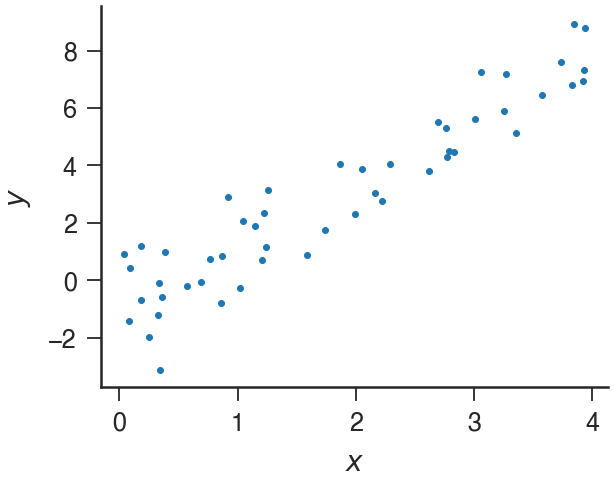

In [72]:
beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 50
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1))

ax.scatter(x, y)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

# Writing our Gibbs sampler

Now we're ready to write the Gibbs sampler. Apart from the data we need to supply initial parameter estimates and hyper parameters. Note that technically we only need to supply all but one of the initial parameters and one of them will be sampled first and that value used for the rest of that iteration.

In [73]:
## specify initial values
init = {"beta_0": 0,
        "beta_1": 0,
        "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}

def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    return trace

Let's test it out!

In [74]:
iters = 1000
trace = gibbs(y, x, iters, init, hypers)

In [76]:
trace=pd.DataFrame(trace)

In [77]:
trace_burnt = trace[-500:]

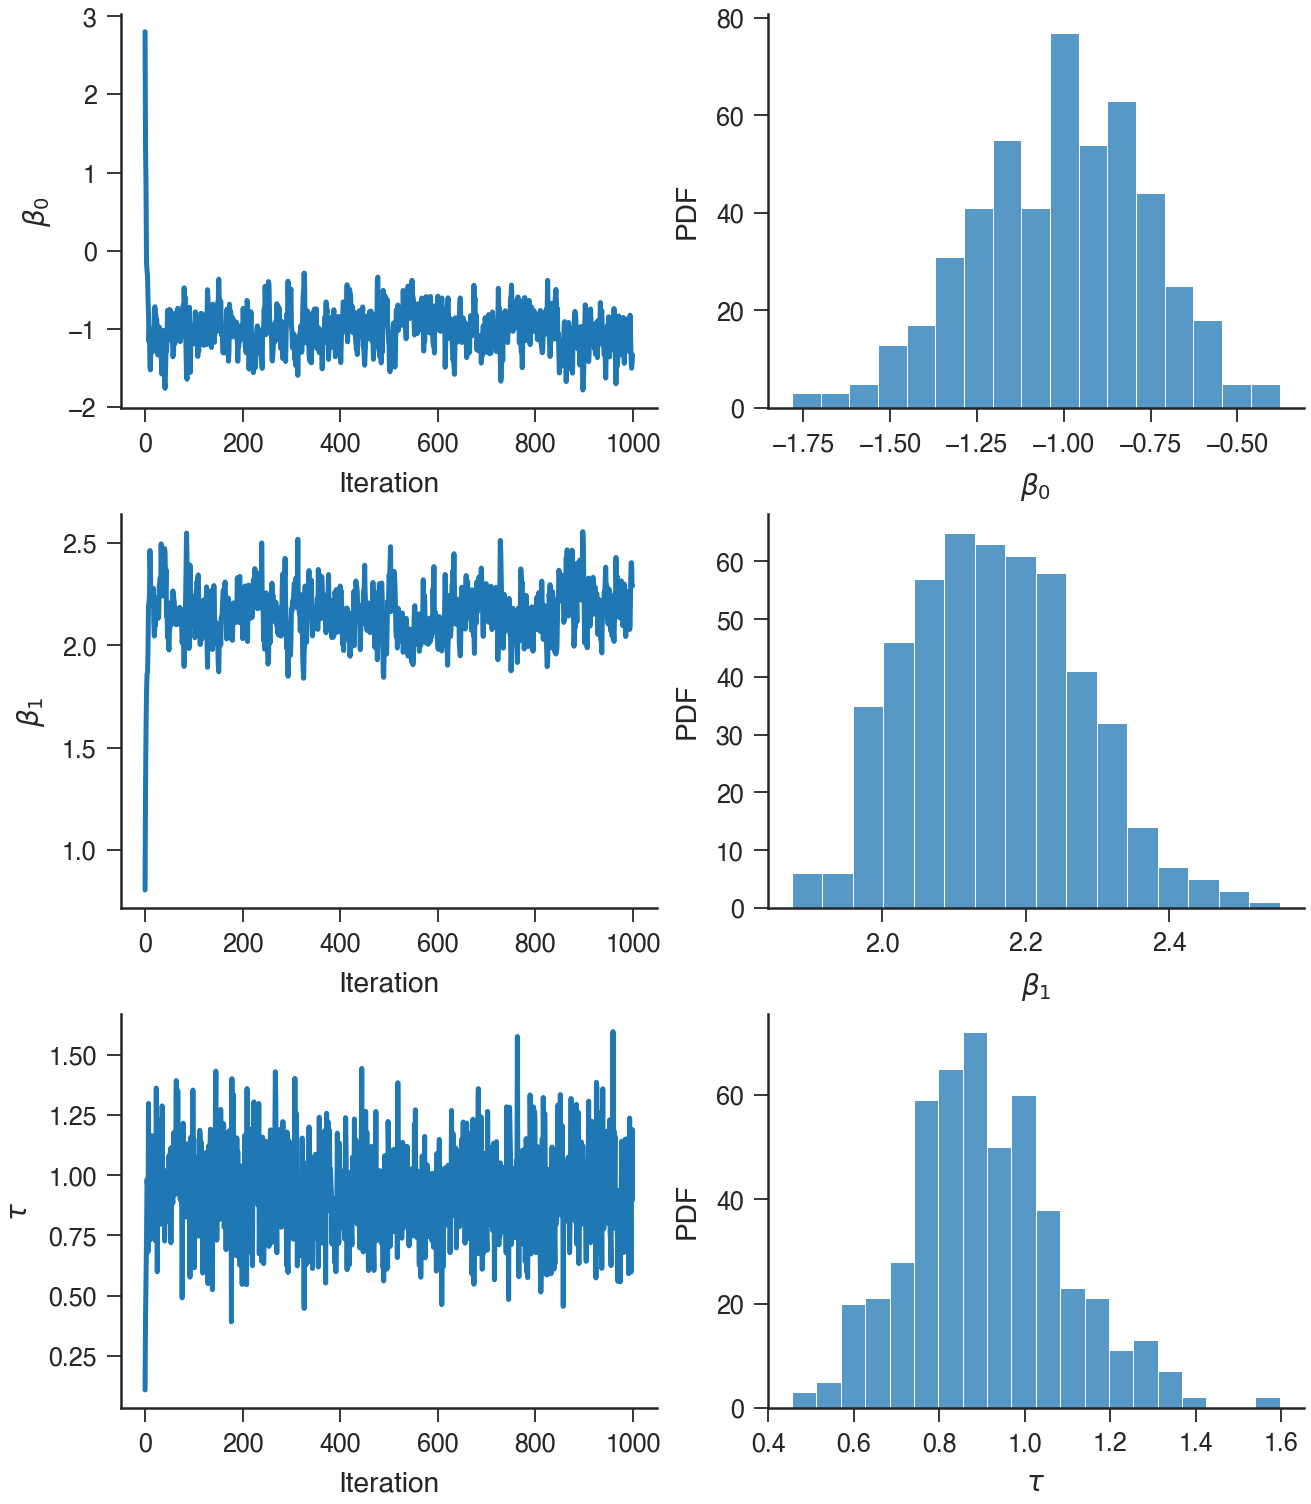

In [78]:
f, axs = plt.subplots(nrows=3, ncols=2, figsize=stdfigsize(nx=2, ny=3, scale=1))
labels=[r'$\beta_0$',r'$\beta_1$',r'$\tau$']
count=0
ax=axs.flatten()[0]
ax.plot(trace[0])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[0])

ax=axs.flatten()[1]
sns.histplot(trace_burnt[0],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[0])

ax=axs.flatten()[2]
ax.plot(trace[1])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[1])

ax=axs.flatten()[3]
sns.histplot(trace_burnt[1],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[1])

ax=axs.flatten()[4]
ax.plot(trace[2])
ax.set_xlabel("Iteration")
ax.set_ylabel(labels[2])

ax=axs.flatten()[5]
sns.histplot(trace_burnt[2],ax=ax)
ax.set_ylabel("PDF")
ax.set_xlabel(labels[2])
f.tight_layout()

In [79]:
print(trace_burnt.median())
print(trace_burnt.std())

0   -0.991321
1    2.152177
2    0.895723
dtype: float64
0    0.251086
1    0.118881
2    0.180747
dtype: float64
